In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dipeshsatav","key":"5a99925228f73111836d576f281a4161"}'}

In [4]:
from google.colab import drive
#drive.mount('/content/drive/')

Mounted at /content/drive


In [11]:
! mkdir -p .kaggle
! cp /content/kaggle.json ~/.kaggle/

In [8]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:39<00:00, 23.2MB/s]
100% 812M/812M [00:39<00:00, 21.7MB/s]


In [13]:
! chmod 600 ~/.kaggle/kaggle.json

In [14]:
! unzip /content/dogs-vs-cats.zip -d dogsvscats

Archive:  /content/dogs-vs-cats.zip
  inflating: dogsvscats/sampleSubmission.csv  
  inflating: dogsvscats/test1.zip    
  inflating: dogsvscats/train.zip    


In [15]:
! unzip -q /content/dogsvscats/test1.zip -d dogsvscats
! unzip -q  /content/dogsvscats/train.zip -d dogsvscats

In [23]:
# just checking if files get loaded correctly
!ls /content/dogsvscats/test1 | wc -l

12500


In [24]:
# first installing all the necessary libraries
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import L2
import warnings
warnings.filterwarnings('ignore')

In [25]:
# just checking if all data is loaded
train_path = '/content/dogsvscats/train'
test_path = '/content/dogsvscats/test1'
print(len(os.listdir(train_path)),len(os.listdir(test_path)))

25000 12500


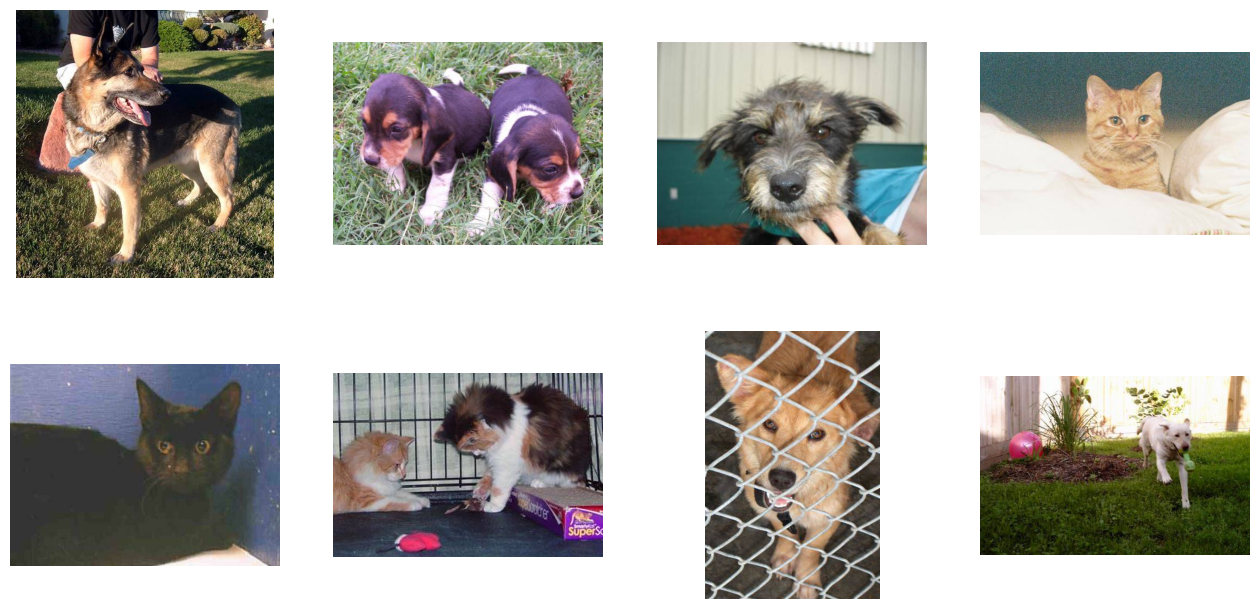

In [26]:
# visualizing the images

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(16,16))

images = os.listdir(train_path)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(train_path, img))
    fig.imshow(img)

In [27]:
parent_dir = '/content/cats-v-dogs'
os.mkdir(parent_dir)

for dir in ['training', 'validation']:
    path = os.path.join(parent_dir , dir)
    os.mkdir(path)
    for dir in ['cats', 'dogs']:
        n_path = os.path.join(path , dir)
        os.mkdir(n_path)


In [28]:
src_dir = train_path

cats_train_dir = 'cats-v-dogs/training/cats'
cats_valid_dir = 'cats-v-dogs/validation/cats'

dogs_train_dir = 'cats-v-dogs/training/dogs'
dogs_valid_dir = 'cats-v-dogs/validation/dogs'

# List of cats names in all training images
cats =[img for img in os.listdir(src_dir) if img[:3] == 'cat']

# List of dogs names in all training images
dogs =[img for img in os.listdir(src_dir) if img[:3] == 'dog']

# Take 10% of training images for validation
np.random.seed(100)
cats_valid_sample = random.sample(cats, int(0.1*len(cats)))
dogs_valid_sample = random.sample(dogs, int(0.1*len(dogs)))

In [29]:
# getting the data in validation folders
for img in os.listdir(src_dir):
    src_img = os.path.join(src_dir, img)

    if img[:3] == 'cat':
        if img in cats_valid_sample:
            dest_img = os.path.join(cats_valid_dir, img)
        else:
            dest_img = os.path.join(cats_train_dir, img)

    elif img[:3] == 'dog':
        if img in dogs_valid_sample:
            dest_img = os.path.join(dogs_valid_dir, img)
        else:
            dest_img = os.path.join(dogs_train_dir, img)
    if not os.path.exists(dest_img):
        shutil.copyfile(src_img, dest_img)

In [36]:
# rescaling the data

train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)


train_dir = 'cats-v-dogs/training'
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(64, 64), batch_size=32, class_mode='binary')

valid_dir = 'cats-v-dogs/validation'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(64, 64), batch_size=32,class_mode='binary')


Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [31]:
# checking class indices
print(valid_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [39]:
# create model
model = Sequential([    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
                        MaxPooling2D(2, 2),
                        Conv2D(64, (3,3), activation='relu'),
                        MaxPooling2D(2,2),
                        Conv2D(128, (3,3), activation='relu'),
                        MaxPooling2D(2,2),

                        Flatten(),
                        Dense(128, activation='relu'),
                        Dense(1, activation='sigmoid')  ])

# Compile model
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 128)        

In [40]:
# fitting
history = model.fit(train_generator, epochs=10, verbose=1,validation_data=valid_generator)

Epoch 1/10
704/704 [==============================] - 41s 55ms/step - loss: 0.5881 - accuracy: 0.6774 - val_loss: 0.5076 - val_accuracy: 0.7548
Epoch 2/10
704/704 [==============================] - 41s 59ms/step - loss: 0.4775 - accuracy: 0.7690 - val_loss: 0.5048 - val_accuracy: 0.7580
Epoch 3/10
704/704 [==============================] - 39s 56ms/step - loss: 0.4340 - accuracy: 0.7985 - val_loss: 0.4718 - val_accuracy: 0.7836
Epoch 4/10
704/704 [==============================] - 41s 58ms/step - loss: 0.4012 - accuracy: 0.8200 - val_loss: 0.4033 - val_accuracy: 0.8192
Epoch 5/10
704/704 [==============================] - 40s 56ms/step - loss: 0.3610 - accuracy: 0.8393 - val_loss: 0.3645 - val_accuracy: 0.8368
Epoch 6/10
704/704 [==============================] - 39s 55ms/step - loss: 0.3316 - accuracy: 0.8564 - val_loss: 0.3446 - val_accuracy: 0.8428
Epoch 7/10
704/704 [==============================] - 40s 57ms/step - loss: 0.2913 - accuracy: 0.8775 - val_loss: 0.3435 - val_accuracy:

<Axes: >

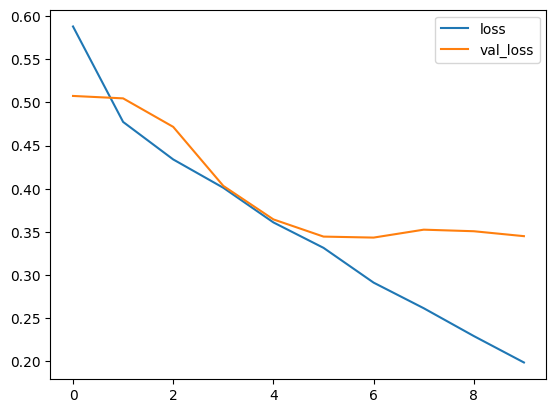

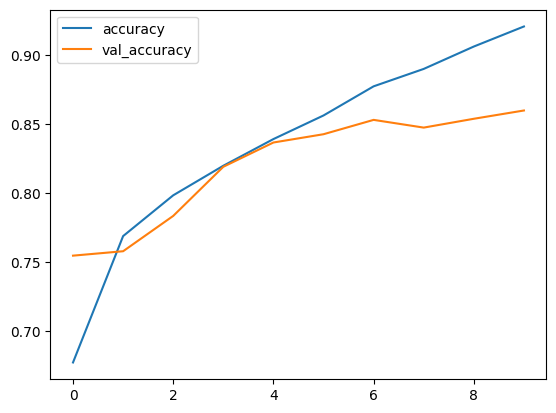

In [41]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [42]:
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(valid_generator)[1]
print("Our Base Model Accuracy on Training Data: ", train_acc)
print("Our Base Model Accuracy on Validation Data: ", valid_acc)

79/79 [==============================] - 3s 40ms/step - loss: 0.3451 - accuracy: 0.8600
Our Base Model Accuracy on Training Data:  0.9512444734573364
Our Base Model Accuracy on Validation Data:  0.8600000143051147
